In [147]:
import pandas as pd
import numpy as np
import sklearn.linear_model
import glob
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
import seaborn as sns

In [148]:
def read_fiels():
    path = r"C:\Users\ksiro\Documents\GitHub\Customer segmentation and live time value\brazilian-ecommerce"
    all_files = glob.glob(path + "/*.csv")
    lis = []
    for filenames in all_files:
        df = pd.read_csv(filenames)
        lis.append(df)
    return lis

In [149]:
def joining_datasets(*kwargs):
    joined = pd.merge(customer,orders, how="inner",on="customer_id")
    joined2 = pd.merge(joined,order_item,how="inner",on="order_id")
    joined3 = pd.merge(joined2,order_payment,how="inner",on="order_id")
    joined4 = pd.merge(joined3,products, how="inner",on="product_id")
    joined5 = pd.merge(joined4,prod_category,how="inner",on="product_category_name")
    return joined5

In [150]:
def missing_values(df):
    fil = df.columns.isin(["order_delivered_carrier_date","order_delivered_customer_date","order_approved_at"])
    df = df.iloc[:,~fil]
    df.fillna(0)
    return df

In [151]:
def filtering(df):
    cols= ["product_category_name","seller_id","customer_city","customer_zip_code_prefix","shipping_limit_date"]
    df = df.iloc[:,~df.columns.isin(cols)]
    return df

In [152]:
def string_to_time(df):
    df.order_purchase_timestamp = pd.to_datetime(df.order_purchase_timestamp)
    return df

In [167]:
def exploration_one(df):
    plt.figure(figsize=(14,5))
    sns.scatterplot(df.payment_installments,df.payment_value).set_title("Total Price vs Number of Installments")
    #plt.scatter(df.payment_installments,df.payment_value)
    #plt.ylabel("Number of Installments")
    #plt.xlabel("Total Payment")

In [154]:
def exploration_two(df):
    plt.figure(figsize=(14,6))
    sns.scatterplot(df.price,df.freight_value).set_title("Price vs Freight Value")
    #plt.scatter(df.price,df.freight_value)
    #plt.ylabel("Price of Item")
    #plt.xlabel("Freight Value")

In [155]:
def feature_engg(df):
    df["volume"] = df.product_length_cm * df.product_width_cm * df.product_width_cm
    df = df.drop(["product_length_cm","product_width_cm","product_width_cm"],axis=1)
    plt.figure(figsize=(12,8))
    sns.scatterplot(df.volume.loc[ (df.volume < 200000) & (df.freight_value>150) ],df.freight_value.loc[ (df.volume <200000) & (df.freight_value>150)])
    #plt.scatter(df.volume.loc[ (df.volume < 200000) & (df.freight_value>150) ],df.freight_value.loc[ (df.volume <200000) & (df.freight_value>150)])
    return df

In [156]:
def sales_only(df):
    df = df.filter(["order_purchase_timestamp","price"])
    df = df.sort_values(by="order_purchase_timestamp")
    df = df.set_index("order_purchase_timestamp")
    df.head()
    return df

In [180]:
def average_sale_each_day(df):
    df = df.iloc[(df.index > "2018-07-01")  ]
    res = df.groupby(df.index.dayofyear).mean()
    plt.figure(figsize=(12,6))
    plt.plot(res)
    plt.title("Average Sale Each Day (Past 2 months)")
    plt.xlabel("Day Number")
    plt.ylabel("Avg_sale")
    return res

In [185]:
def correlations(df):
    plt.figure(figsize=(12,8))
    plot_acf(res, lags=20)
    test = pd.concat([res.shift(1),res],axis=1)
    print(test.corr())

In [159]:
def forecasting(df):
    warnings.filterwarnings("ignore", category=FutureWarning)
    model = AR(df)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(df),end=len(df)+30 , dynamic=False)
    
    plt.figure(figsize=(14,7))
    pred.index = list(range(max(df.index),max(df.index)+31))
    plt.plot(df)
    plt.plot(pred)
    plt.title("Next 30 Predictions")
    plt.xlabel("Day number")
    plt.ylabel("Avg sale in Dollar")
    return model_fit

In [160]:
lis = read_fiels()
customer = lis[0]
geolocation = lis[1]
orders = lis[2]
order_item = lis[3]
order_payment = lis[4]
order_review = lis[5]
products = lis[6]
sellers = lis[7]
prod_category = lis[8]
del lis

In [161]:
df = joining_datasets(customer,geolocation,orders,order_item,products,prod_category)

In [162]:
df = missing_values(df)

In [163]:
df = filtering(df)

In [164]:
df = string_to_time(df)

In [165]:
df.isna().sum()

customer_id                      0
customer_unique_id               0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_estimated_delivery_date    0
order_item_id                    0
product_id                       0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 1
product_length_cm                1
product_height_cm                1
product_width_cm                 1
product_category_name_english    0
dtype: int64

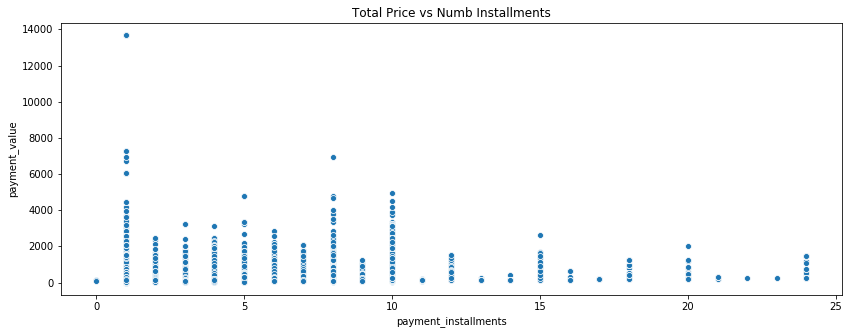

In [166]:
exploration_one(df)

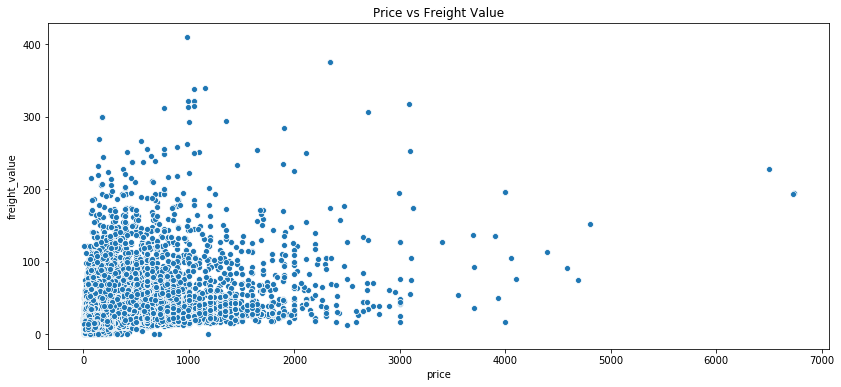

In [168]:
exploration_two(df)

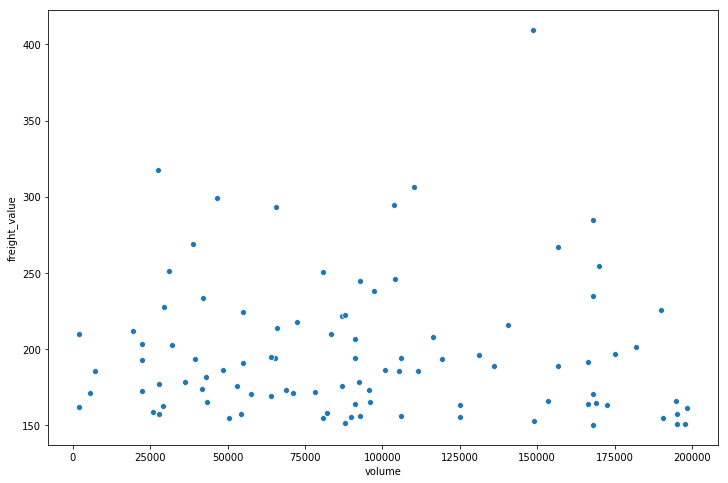

In [169]:
df = feature_engg(df)

In [170]:
sales = sales_only(df)

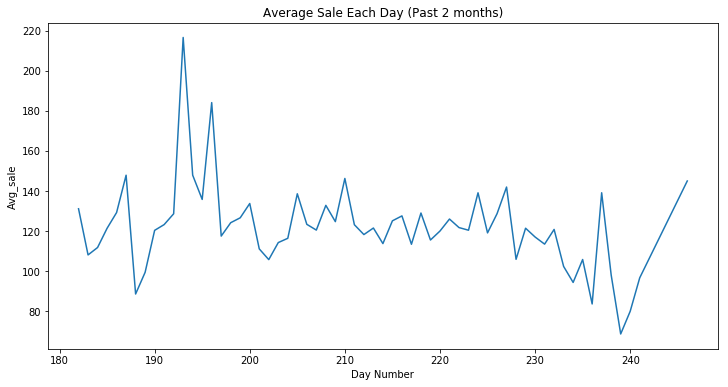

In [181]:
avg_sale = average_sale_each_day(sales)

          price     price
price  1.000000  0.300632
price  0.300632  1.000000


<Figure size 864x576 with 0 Axes>

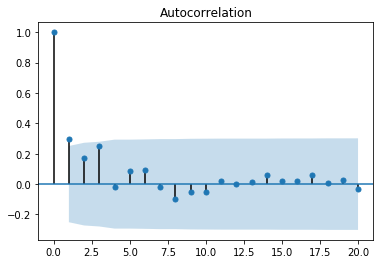

In [186]:
correlations(avg_sale)

Lag Values 
const        67.813260
L1.price      0.322466
L2.price      0.141198
L3.price      0.259714
L4.price     -0.379018
L5.price      0.064142
L6.price      0.134740
L7.price      0.122702
L8.price     -0.303088
L9.price     -0.114406
L10.price     0.012312
L11.price     0.187628
dtype: float64 


C:\Users\ksiro\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ksiro\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


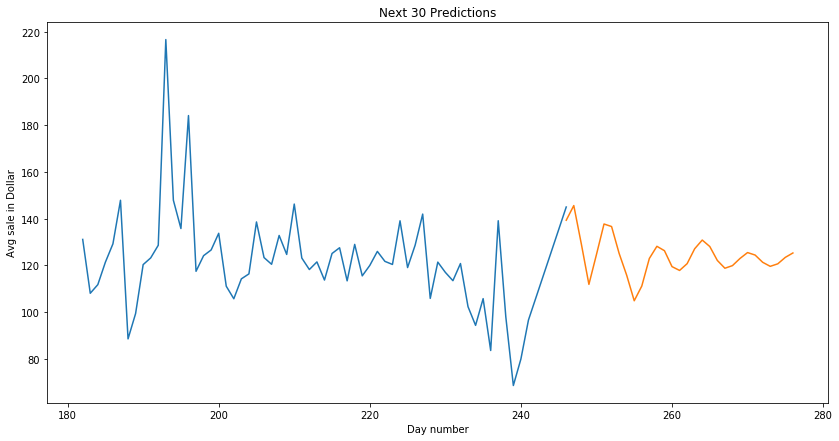

In [187]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
model_fit = forecasting(avg_sale)
print("Lag Values \n{} ".format(model_fit.params))